<a href="https://colab.research.google.com/github/Rafie1715/Capstone-Project-IBM-Granite-Data-Anayltics/blob/main/Capstone_Project_IBM_Granite_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# 1. Install library Replicate
!pip install replicate

# 2. Import semua library yang dibutuhkan
import os
import pandas as pd
import replicate
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

# 3. Konfigurasi API Token dari Colab Secrets
# Pastikan Anda sudah menyimpan token dengan nama 'REPLICATE_API_TOKEN'
try:
    REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
    os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
    print("API Token Replicate berhasil dikonfigurasi.")
except userdata.SecretNotFoundError:
    print("Error: Secret 'REPLICATE_API_TOKEN' tidak ditemukan. Harap simpan token Anda di Colab Secrets.")

API Token Replicate berhasil dikonfigurasi.


In [26]:
from google.colab import files

# 1. Minta pengguna untuk mengunggah file kaggle.json
print("Silakan unggah file 'kaggle.json' Anda.")
uploaded = files.upload()

# 2. Konfigurasi file kaggle.json
if not uploaded:
    print("\n❌ Anda tidak mengunggah file. Harap jalankan sel ini lagi.")
else:
    filename = list(uploaded.keys())[0]
    !mkdir -p ~/.kaggle
    !mv "{filename}" ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    print("\n✅ File 'kaggle.json' berhasil dikonfigurasi.")

    # 3. Unduh dataset dari Kaggle (sesuai link yang Anda berikan)
    !kaggle datasets download -d farhan999/tokopedia-product-reviews

    # 4. Unzip file dataset
    !unzip -o tokopedia-product-reviews.zip
    print("\n✅ Dataset berhasil diunduh dan di-unzip.")

Silakan unggah file 'kaggle.json' Anda.


Saving kaggle.json to kaggle (3).json

✅ File 'kaggle.json' berhasil dikonfigurasi.
Dataset URL: https://www.kaggle.com/datasets/farhan999/tokopedia-product-reviews
License(s): MIT
tokopedia-product-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tokopedia-product-reviews.zip
  inflating: tokopedia-product-reviews-2019.csv  

✅ Dataset berhasil diunduh dan di-unzip.


In [28]:
df = pd.read_csv('tokopedia-product-reviews-2019.csv')
df_analysis = df[['rating', 'text']].copy()
df_analysis.dropna(subset=['text'], inplace=True) # Hapus ulasan kosong

# --- LANGKAH PENTING: Membuat Kolom Sentimen dari Rating ---
def tentukan_sentimen(rating):
    if rating >= 4:
      return 'positif'
    elif rating == 3:
      return 'netral'
    else: # rating 1 atau 2
      return 'negatif'

df_analysis['sentimen'] = df_analysis['rating'].apply(tentukan_sentimen)

print("\n✅ Dataset siap untuk dianalisis (kolom 'sentimen' sudah dibuat).")
print(f"Jumlah data: {len(df_analysis)} ulasan.")
print("\nContoh 5 baris data pertama:")
print(df_analysis.head())


✅ Dataset siap untuk dianalisis (kolom 'sentimen' sudah dibuat).
Jumlah data: 40607 ulasan.

Contoh 5 baris data pertama:
   rating                                             text sentimen
0       5           Barang sesuai pesanan dan cepat sampai  positif
1       5                         Barang bagus harga murah  positif
2       5  Paket rapi...mantap....cepat....sampe ke tujuan  positif
3       5                       ya saya puas dgn barangnya  positif
4       5                     Responya luar biasa b mantap  positif


In [29]:
# Nama model IBM Granite di Replicate
MODEL_ID = "ibm-granite/granite-3.3-8b-instruct"

# Fungsi untuk bertanya ke model Granite melalui Replicate
def ask_granite_replicate(prompt):
    """Mengirim prompt ke model Granite di Replicate dan mengembalikan respons."""
    try:
        output = replicate.run(
            MODEL_ID,
            input={"prompt": prompt, "prompt_template": "{prompt}"}
        )
        full_response = "".join(output)
        return full_response.strip()
    except Exception as e:
        return f"Error: {e}"

print("✅ Fungsi 'ask_granite_replicate' siap digunakan.")

✅ Fungsi 'ask_granite_replicate' siap digunakan.


In [30]:
# Ambil 10 contoh ulasan negatif untuk dianalisis oleh AI
negative_reviews = df_analysis[df_analysis['sentimen'] == 'negatif']['text'].head(10).tolist()
negative_reviews_text = "\n- ".join(negative_reviews)

# --- AI Task 1: Summarization ---
summarization_prompt = f"""
Analisis ulasan-ulasan negatif berikut dari pelanggan Tokopedia.
Identifikasi dan rangkum 3 topik keluhan utama yang paling sering muncul.
Berikan jawaban dalam format daftar bernomor dalam Bahasa Indonesia.

Ulasan Pelanggan:
- {negative_reviews_text}

Top 3 Topik Keluhan:
1.
2.
3.
"""
print("Meringkas topik keluhan utama menggunakan AI...")
complaint_topics = ask_granite_replicate(summarization_prompt)
print("--- Topik Utama Keluhan ---")
print(complaint_topics)

# --- AI Task 2: Recommendation Generation ---
recommendation_prompt = f"""
Seorang penjual di Tokopedia menerima keluhan dengan topik utama sebagai berikut:
{complaint_topics}

Berdasarkan masalah tersebut, berikan tiga rekomendasi bisnis yang konkret dan dapat ditindaklanjuti (actionable) untuk penjual.
Format jawaban sebagai daftar bernomor dengan penjelasan singkat dalam Bahasa Indonesia.

Rekomendasi untuk Penjual:
1. [Rekomendasi 1] - [Penjelasan singkat]
2. [Rekomendasi 2] - [Penjelasan singkat]
3. [Rekomendasi 3] - [Penjelasan singkat]
"""
print("\nMembuat rekomendasi bisnis menggunakan AI...")
business_recommendations = ask_granite_replicate(recommendation_prompt)
print("--- Rekomendasi Actionable untuk Penjual ---")
print(business_recommendations)

Meringkas topik keluhan utama menggunakan AI...
--- Topik Utama Keluhan ---
1. Barang yang dikirim tidak sesuai pesanan: Ulasan-ulasan pelanggan menunjukkan bahwa barang yang mereka terima tidak sesuai dengan pesanan yang mereka lakukan. Ini termasuk kesalahan dalam ukuran, kualitas, atau spesifikasi yang tidak sesuai dengan yang diinginkan.

2. Masalah pengiriman dan kondisi barang: Beberapa pelanggan menyebutkan bahwa pengiriman mereka cepat, tetapi barang yang diterima rusak atau dalam kondisi buruk. Komplain juga terdengar tentang kemacetan atau gangguan dalam proses pengiriman.

3. Kesalahan dalam deskripsi produk: Keterangannya yang tidak tepat dalam deskripsi produk adalah masalah lain yang sering muncul. Pelanggan menyadari bahwa isi atau fitur yang dijelaskan dalam deskripsi produk tidak sesuai dengan apa yang mereka terima, menyebabkan kekecewaan.

Catatan: Ulasan-ulasan di atas terdiri dari teks konversasi dan menggunakan bahasa yang sedikit tidak rapi. Karena itu, interpret

/tmp/ipython-input-1750698462.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', order=order)


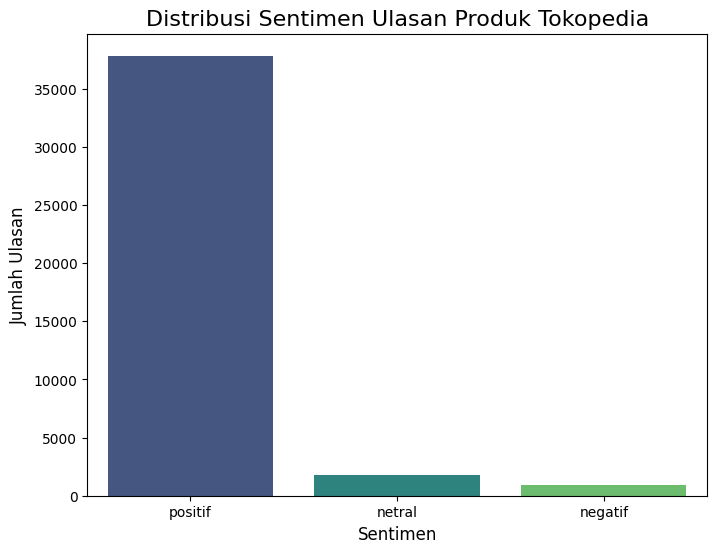

--- Insight & Findings ---
1. Distribusi Sentimen: Dari total 40607 ulasan, mayoritas pelanggan memberikan ulasan 'positif'. Namun, terdapat sejumlah ulasan 'negatif' yang perlu dianalisis lebih dalam untuk menemukan area perbaikan.

2. Akar Masalah Pelanggan Tidak Puas: Analisis AI pada ulasan negatif menemukan tiga akar masalah utama, yaitu:
1. Barang yang dikirim tidak sesuai pesanan: Ulasan-ulasan pelanggan menunjukkan bahwa barang yang mereka terima tidak sesuai dengan pesanan yang mereka lakukan. Ini termasuk kesalahan dalam ukuran, kualitas, atau spesifikasi yang tidak sesuai dengan yang diinginkan.

2. Masalah pengiriman dan kondisi barang: Beberapa pelanggan menyebutkan bahwa pengiriman mereka cepat, tetapi barang yang diterima rusak atau dalam kondisi buruk. Komplain juga terdengar tentang kemacetan atau gangguan dalam proses pengiriman.

3. Kesalahan dalam deskripsi produk: Keterangannya yang tidak tepat dalam deskripsi produk adalah masalah lain yang sering muncul. Pelangga

In [31]:
# Hitung jumlah ulasan per sentimen
sentiment_counts = df_analysis['sentimen'].value_counts()

# Buat visualisasi
plt.figure(figsize=(8, 6))
# Tentukan urutan bar agar lebih logis: positif, netral, negatif
order = ['positif', 'netral', 'negatif']
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', order=order)
plt.title('Distribusi Sentimen Ulasan Produk Tokopedia', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

# Tulis narasi untuk laporan
print("--- Insight & Findings ---")
print(f"1. Distribusi Sentimen: Dari total {len(df_analysis)} ulasan, mayoritas pelanggan memberikan ulasan 'positif'. Namun, terdapat sejumlah ulasan 'negatif' yang perlu dianalisis lebih dalam untuk menemukan area perbaikan.")
print("\n2. Akar Masalah Pelanggan Tidak Puas: Analisis AI pada ulasan negatif menemukan tiga akar masalah utama, yaitu:")
print(complaint_topics)

print("\n--- Conclusion & Recommendation ---")
print("Kesimpulan: Kunci untuk meningkatkan rating toko adalah dengan secara proaktif mengatasi masalah-masalah yang diangkat dalam ulasan negatif.")
print("Rekomendasi Berbasis AI untuk Penjual:")
print(business_recommendations)

print("\n--- AI Support Explanation ---")
print("Pada proyek ini, model AI IBM Granite digunakan untuk:")
print("1. **Summarization:** Menganalisis ulasan pelanggan dalam Bahasa Indonesia untuk mengekstrak dan merangkum tema-tema keluhan utama.")
print("2. **Recommendation Generation:** Memberikan rekomendasi bisnis yang praktis dan dapat ditindaklanjuti oleh penjual e-commerce berdasarkan masalah yang teridentifikasi.")